# Analysis of Causal Effects of Progresa Welfare Program (Mexico-1997)

## Namrata Deshpande
### Feb 10, 2017

Note: This project was done as part of University of Washington course INFX 574 C: Data Science II: Machine Learning And Econometrics under the guidance of Prof. Jewin West and Prof. Ott Toomet.

## Introduction

For this project, we will be using data from the [Progresa program](http://en.wikipedia.org/wiki/Oportunidades), a government social assistance program in Mexico. The approaches used here for evaluation of impact are same as those described in the paper "[School subsidies for the poor: evaluating the Mexican Progresa poverty program](http://www.sciencedirect.com/science/article/pii/S0304387803001858)", by Paul Shultz. 

The goal of this project is to implement some of the basic econometric techniques to measure the impact of Progresa on secondary school enrollment rates. The timeline of the program was:

 * Baseline survey conducted in 1997
 * Intervention begins in 1998, "Wave 1" of data collected in 1998
 * "Wave 2 of data" collected in 1999
 * Evaluation ends in 2000, at which point the control villages were treated. 
 
The data are actual data collected to evaluate the impact of the Progresa program.  In this file, each row corresponds to an observation taken for a given child for a given year. There are two years of data (1997 and 1998), and just under 40,000 children who are surveyed in each year. For each child-year observation, the following variables are collected:

| Variable name | Description|
|---------|---------|
|year	  |year in which data is collected
|sex	  |male = 1|
|indig	  |indigenous = 1|
|dist_sec |nearest distance to a secondary school|
|sc	      |enrolled in school in year of survey|
|grc      |grade enrolled|
|fam_n    |family size|
|min_dist |	min distance to an urban center|
|dist_cap |	min distance to the capital|
|poor     |	poor = 1|
|progresa |treatment =1|
|hohedu	  |years of schooling of head of household|
|hohwag	  |monthly wages of head of household|
|welfare_index|	welfare index used to classify poor|
|hohsex	  |gender of head of household (male=1)|
|hohage   |age of head of household|
|age      |years old|
|folnum	  |individual id|
|village  |	village id|
|sc97	  |schooling in 1997|

In [1]:
#Importing required libraries
import IPython

import numpy as np

import scipy as sp

import pandas as pd

import matplotlib

import sklearn

import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')

---

## Part 1: Descriptive analysis

### 1.1	Summary Statistics

First we will calculate summary statistics (mean and standard deviation) for all of the demographic variables in the dataset (i.e., everything except year, folnum, village). This step will help in understanding the shape of data we are dealing with.

In [2]:
#importing the progresa data from csv file
progresa_df= pd.read_csv('progresa_sample.csv')
#number of rows and columns in the dataset
print (progresa_df.shape)
#Name and datatype of columns
print (progresa_df.columns)
#dtypes in progresa_df
print (progresa_df.dtypes)

(77250, 21)
Index(['year', 'sex', 'indig', 'dist_sec', 'sc', 'grc', 'fam_n', 'min_dist',
       'dist_cap', 'poor', 'progresa', 'hohedu', 'hohwag', 'welfare_index',
       'hohsex', 'hohage', 'age', 'village', 'folnum', 'grc97', 'sc97'],
      dtype='object')
year               int64
sex              float64
indig            float64
dist_sec         float64
sc               float64
grc              float64
fam_n              int64
min_dist         float64
dist_cap         float64
poor              object
progresa          object
hohedu             int64
hohwag           float64
welfare_index    float64
hohsex           float64
hohage           float64
age                int64
village            int64
folnum             int64
grc97              int64
sc97             float64
dtype: object


In [3]:
#Summary Stats
#dropping non demographical variables
df= progresa_df.drop(['year', 'folnum', 'village'], axis=1)
#calculating mean and standard deviation and arranging alphabetically
pd.DataFrame(df.dropna().describe().loc[['mean','std']].transpose()).sort_index(axis=0)


,mean,std
age,11.141369,2.995374
dist_cap,148.747707,77.134043
dist_sec,2.346990,2.111281
fam_n,7.224666,2.329421
grc,4.089494,2.447608
grc97,3.762656,2.449568
hohage,44.262224,11.457772
hohedu,2.853908,2.655106
hohsex,0.927744,0.258914
hohwag,592.782484,791.378223


In [4]:
#summary of categorical variables
#including sex and hohsex as well as category
df1 = df.copy()
df1['sex'] = df1['sex'].astype('category')
df1['hohsex'] = df1['hohsex'].astype('category')
pd.DataFrame(df1.describe(include=['object', 'category']).transpose()).sort_index(axis=0)

,count,unique,top,freq
hohsex,77230,2,1,71452
poor,77250,2,pobre,65392
progresa,77250,2,basal,47560
sex,77226,2,1,39556


### 1.2 Baseline Differences

In this section we will check whether the baseline (1997) demographic characteristics **for the poor**  different in treatment and control villages? For this we will use a T-Test to determine whether there is a statistically significant difference in the average values of each of the variables in the dataset and focus only on the data from 1997 for individuals who are poor (i.e., poor=='pobre').

In [5]:
#filtering data for poor=pobre and year=97
df1= progresa_df[(progresa_df['year']==97) & (progresa_df['poor'] =='pobre')]
#dropping insignificant columns
df1= df1.drop(['year', 'folnum', 'village','poor'], axis=1)
#seperating control and treatment groups by progresa column values
treat = df1[df1['progresa']=='basal'].drop(['progresa'], axis=1)
control =df1[df1['progresa']=='0'].drop(['progresa'],axis=1)
#removing na values from treatment and control
treat = treat.dropna()
control = control.dropna()
#Final Combined Table
baseline = pd.DataFrame({ 'Variable name': treat.transpose().index,
                       'Average value (Treatment villages)': treat.describe().loc['mean'].transpose(),
                        'Average value (Control villages)': control.describe().loc['mean'].transpose() })
#calculating differences in averages
baseline['Difference (Treat - Control)'] = baseline['Average value (Treatment villages)']- baseline[ 'Average value (Control villages)']
#calculating p-values after running t test and adding to table
#two independent samples with unequal variance t-test is run 
baseline['p-value']= stats.ttest_ind(treat, control, equal_var=False).pvalue
#removing extra indexes
baseline.set_index('Variable name', inplace=True)
baseline.head(16)



,Average value (Control villages),Average value (Treatment villages),Difference (Treat - Control),p-value
Variable name,,,,
sex,0.506556,0.520268,0.013713,1.959334e-02
indig,0.325306,0.316744,-0.008562,1.190039e-01
dist_sec,2.400687,2.399648,-0.001039,9.680703e-01
sc,0.815066,0.822697,0.007631,9.246651e-02
grc,3.733653,3.709214,-0.024439,3.955066e-01
fam_n,7.302939,7.281032,-0.021907,4.260542e-01
min_dist,103.098348,107.395231,4.296884,6.942943e-18
dist_cap,154.492095,151.801472,-2.690622,4.361914e-03
hohedu,2.660982,2.726729,0.065747,2.495527e-02


### 1.3 Interpretation of Results


#### A: statistically significant differences: 
Although there is no statisticaly significant difference in the enrollment rate (sc) for the treatment and control groups in 1997 (as seen from p-value >0.05), the differences in other variables especially those associated with the head of the family and the location of village are showing high significance. For example, the age, education as well as wages of head of the family (hohage, hohedu, hohwag) have p-values lower than 0.05 showing significant difference. Same is true for distance from urban center and capital (min_dist, dist_cap) for the villages of the two groups.
#### B: Why does it matter if there are differences at baseline?
The success and validity of output of experiments involving testing on treatment and control groups (ex. A/B testing) depends upon the assumption that the treatment and control groups are selected purely by random sampling and hence both groups are equally representative of the different variables with no statistically significant difference in variables of interest. Only if this assumption is true, we can estimate the true effect of the experiment. If there are significant differences between these two groups then such variables may cause difference in output of experiment which is not related to or due to our experiment. These might also cause, in some cases, the variables to be non-exgenous as some error terms could depend upon these variables. Hence, it is important that there should be no significant differences between variables of interest.
#### C: Further steps to be taken: 
As there are some significant difference in some variables in the treatment and control groups at baseline, while measuring the effect of treatment, we have to consider the impact of these variables along with our treatment. For example if we are creating a regression model then we have to consider the effect of these control variables as well along with our treatment effect to find out the true treatment effect.

### 1.4 Graphical exploration, part 1

In the next two sections we will explore the data graphically. 

In this section we will compute the average enrollment rate in 1997 for each level of household head education and then create a scatterplot to understand the relationships if any.

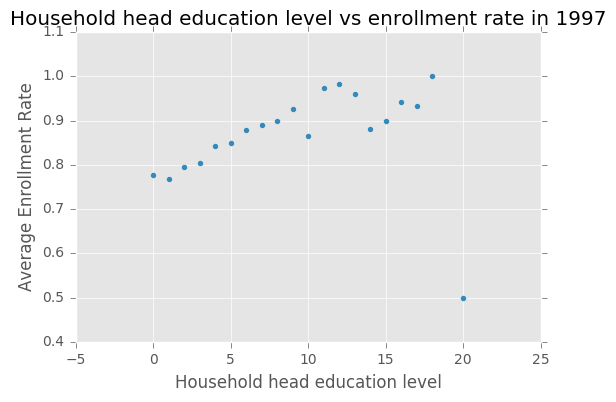

In [6]:
#filtering by year 1997 and grouping by household head education level 
# calculating mean of school enrollment
df1 = pd.DataFrame(progresa_df[progresa_df['year']==97].groupby('hohedu', as_index=False)['sc'].mean())
#plotting the two variables
ax = df1.plot(x='hohedu', y='sc', kind='scatter', title='Household head education level vs enrollment rate in 1997')
ax.set_xlabel('Household head education level')
ax.set_ylabel('Average Enrollment Rate')
plt.show()

The scatterplot between the two variables for the year 1997 shows that for household head education level values less than 12, there is almost linear positive association between the two. After level 12 there is somewhat non-linear relation. So, in year 1997, before the progresa subsidy was provided, the average school enrollment rate shows somewhat positive association with household head education level upto a level of 12.

### 1.5 Graphical exploration, part 2

In this section we will create a histogram of village enrollment rates **among poor households in treated villages**, before and after treatment and then analyze the differences.

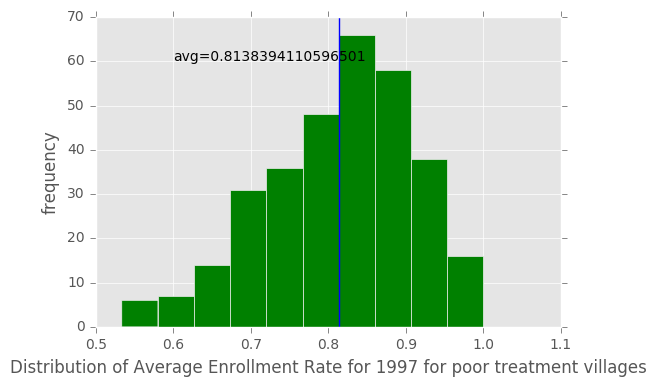

In [7]:
#selecting only poor treatment villages
df2 = progresa_df[(progresa_df['progresa']=='basal') & (progresa_df['poor'] =='pobre')]
#grouping by year and villageids and calculating average enrollment rate per village
df2 = pd.DataFrame(df2.groupby(['year','village'], as_index=False)['sc'].mean())
#overall average for 1997
avg_97 = df2[df2['year']==97]['sc'].mean()
#plotting distribution for year 1997
plt.hist(df2[df2['year']==97]['sc'], facecolor='green')
plt.xlabel('Distribution of Average Enrollment Rate for 1997 for poor treatment villages')
plt.ylabel('frequency')
#adding line for overall average
plt.axvline(x= avg_97)
plt.text(0.6, 60, 'avg='+ str(avg_97))
plt.show()




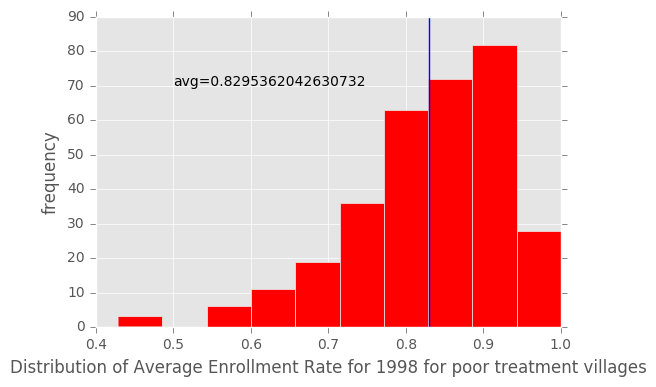

In [8]:
#overall average for 1998
avg_98 = df2[df2['year']==98]['sc'].mean()
#plotting distribution for year 1998
plt.hist(df2[df2['year']==98]['sc'], facecolor='red')
plt.xlabel('Distribution of Average Enrollment Rate for 1998 for poor treatment villages')
plt.ylabel('frequency')
#adding line for overall average
plt.axvline(x= avg_98)
plt.text(0.5, 70, 'avg='+ str(avg_98))
plt.show()

In [9]:
#t-test on enrollment rate in 1997 and 1998
pValue = stats.ttest_ind(df2[df2['year']==97]['sc'], df2[df2['year']==98]['sc'], equal_var=False).pvalue
print('P-value for the t-test: ', pValue)


P-value for the t-test:  0.0442493434226


The histograms as well as the p-value of t-test tells us that the difference between the two means is statistically significant. Apart from the difference in mean, the distribution in 1998 seems more left skewed than the one in 1997 showing more higher values for enrollment rates. In this question we are calculating differences in eligible (poor) treatment group's enrollment rates before and after treatment, i.e. over time. 

## Part 2: Measuring Impact

### 2.1 Simple differences: T-test

For the first step of measuring impact, we will perform some basic analysis for differences in enrollment rate in treatment and control village. For this we will:

* calculate the average enrollment rate among **poor** households in the Treatment villages and the average enrollment rate among **poor** households in the control villages.
* Use a t-test to determine if this difference is statistically significant.

In [10]:
#filtering data for year 1998 and poor houses
df3 = progresa_df[(progresa_df['year']==98) & (progresa_df['poor']=='pobre')].dropna()
#seperating treatment and control and calculating average
treat = df3[df3['progresa']=='basal']
control = df3[df3['progresa']=='0']
#enrollment averages
treatEnroll = treat['sc'].mean()
controlEnroll = control['sc'].mean()
print('Average Enrollment for Treatment villages in 1998:', treatEnroll)
print('Average Enrollment for Control Villages in 1998:', controlEnroll)
print('Difference in Average: (treat-control):', treatEnroll-controlEnroll)
#t-test
pValue = stats.ttest_ind(treat['sc'], control['sc'], equal_var=False).pvalue
print('P-value for T-test: ', pValue)



Average Enrollment for Treatment villages in 1998: 0.849257030578411
Average Enrollment for Control Villages in 1998: 0.810923092511906
Difference in Average: (treat-control): 0.03833393806650498
P-value for T-test:  2.40921106138e-15


The p-value from the t-test tells us that the difference is significant between the average enrollment rate in 1998 for poor treatment and control group. The significant difference gives us a hint that progresa subsidy might have a hand in increasing the enrollment rates of treatment villages. But, to confirm this other control variables should also be considered.

In this we are calculating the difference between enrollment rates for treatment group and control group after the program has taken place (1998).

### 2.2 Simple differences: Regression

Now we will estimate the effects of Progresa on enrollment using a regression model, by regressing the 1998 enrollment rates **of the poor** on treatment assignment.


In [11]:
#filtering data for year 1998 and poor houses
df3 = progresa_df[(progresa_df['year']==98) & (progresa_df['poor']=='pobre')].dropna()
#linear regression model over sc and treatment factor
mod = smf.ols(formula='sc ~ progresa', data = df3)
result = mod.fit()
#summary of fit 
print (result.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     65.64
Date:                Mon, 13 Feb 2017   Prob (F-statistic):           5.66e-16
Time:                        15:02:56   Log-Likelihood:                -11171.
No. Observations:               26155   AIC:                         2.235e+04
Df Residuals:                   26153   BIC:                         2.236e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept             0.8109      0.00

According to the linear regression model fitted in above step, the progresa subsidy increase the likelihood of a child enrolling by 0.0383 units. The p-value for this estimator shows that it is very significant, although low R-squared values denotes the presence of other control variables that also effects the enrollment rate.

The estimator calculated in this step is almost equal to the one calculated in the previous step denoting same effect of progresa subsidy. As the p-value of estimator is very low we can definitely say that we can reject the hypothesis that the effect of treatment is null. Although, we can reject the null hypothesis, more work is required to estimate the true effect of treatment as the model is not showing good goodness-of-fit values.

According to David Hume's defination of counterfactual condition: "We may define a cause to be an object followed by another ... where, if the first object had not been, the second never had existed." (Menzies, 2014). So, in case of this regression the counterfactual condition would state that: If the treatment was not present, i.e. in case of no existence of progresa subsidies, the significant difference that we found in enrollment rate of eligible villages would also be non-existent, i.e. no significant difference would be there in enrollment rate if progresa is not there.



### 2.3 Multiple Regression

As we saw earlier there are several variables other than the progresa treatment that have a significant impact on enrollment rates. So, we have to consider these variables as well while analyzing the program impact. We will re-run the above regression estimated but this time include a set of control variables, for instance, age, distance to a secondary school, gender, education of household head, indigenous, etc.


In [12]:
#filtering data for year 1998 and poor houses
df3 = progresa_df[(progresa_df['year']==98) & (progresa_df['poor']=='pobre')].dropna().copy()
#taking sex and indig variables as categorical with two categories: 0.0 and 1.0
df3['sex'] = df3['sex'].astype('category')
df3['indig'] = df3['indig'].astype('category')
#fitting multiple regression model by least sqaures
mod1 = smf.ols(formula='sc ~ progresa+age+dist_sec+sex+hohedu+indig', data = df3)
result1 = mod1.fit()
#printing the summary of the fit
print (result1.summary())


                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     1557.
Date:                Mon, 13 Feb 2017   Prob (F-statistic):               0.00
Time:                        15:04:43   Log-Likelihood:                -7208.4
No. Observations:               26155   AIC:                         1.443e+04
Df Residuals:                   26148   BIC:                         1.449e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept             1.5206      0.01

After adding the control variables to the regression model we can see that the estimator for coeffcient of effect of treatment decreased sligthly from 0.0383 to 0.0349. On the other hand the standard error for the estimator falls down from 0.005 to 0.004 due to this change. This estimate of 0.0349 gives the effect of progresa subsidy on enrollment rate when other control variables are held constant. So, this estimate somewhat reduce the effect of other control variables and is more towards the true effect of treatment. The estimate in the previous step was not considering the effect of these control variables and hence was not giving us the true effect.

The results tells us that, as noted in previous steps, the change in enrollment is not effected only by treatment and other control variables like age, education of head of house, etc., are also having some effect on it. As we have included these variables in the model estimation the point estimate for treatment is shifted more towards its actual value by reducing the standard error. Also, the R squared value tells us that the model is also better than the previous one.

### 2.4 Difference-in-Difference, version 1 (tabular)

Thus far, we have computed the effects of Progresa by estimating the difference in 1998 enrollment rates across villages. An alternative approach would be to compute the treatment effect using a difference-in-differences framework.

We will begin by estimating the average treatment effects of the program for poor households using data from 1997 and 1998. Specifically, we will calculate the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages; then compute the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages. The difference between these two differences is the final estimate.

In [13]:
#the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages
df4 = progresa_df[(progresa_df['poor']=='pobre') & (progresa_df['progresa']=='basal')].dropna()
#group by year and calculate average enrollment rate
df41 = pd.DataFrame(df4.groupby('year', as_index=False)['sc'].mean())
#first difference
D1= df41['sc'][1]-df41['sc'][0]
print('First Difference estimate:', D1)
#the difference (between 1997 and 1998) in enrollment rates among poor households in control villages
df5 = progresa_df[(progresa_df['poor']=='pobre') & (progresa_df['progresa']=='0')].dropna()
#group by year and calculate average enrollment rate
df51 = pd.DataFrame(df5.groupby('year', as_index=False)['sc'].mean())
#second difference
D2= df51['sc'][1]-df51['sc'][0]
print('Sec Difference estimate:', D2)

#difference in difference
DD = D1-D2
print('Difference in Difference estimate:', DD)

First Difference estimate: 0.0265605074256
Sec Difference estimate: -0.004142465805
Difference in Difference estimate: 0.0307029732307


The estimate calculated by difference in differences framework lowered the effect of treatment further from 0.0349 in previous model to 0.0307. This is because this framework is taking baseline differences (at 1997 before treatment) in consideration and is calculating the effects by measuring the increase or decrease over time. So, this model gives us the factor by which the enrollment rate increased from its base value in 1997 in the two groups. As, this value is considering baseline effects over time, this is more accurate than the simple difference method where the baseline values were not considered.

**Counterfactual Assumption: ** The conterfactual condition underlying this estimate is that without the presence of progresa subsidy the difference in enrollment rate over time from 1997 to 1998 in the two groups would not be statistically significant. 

### 2.5 Difference-in-Difference, version 1 (regression)

Now we will use a regression specification to estimate the average treatment effect of the program (on the poor) in a difference-in-differences framework.

In [14]:
# selecting only poor, copying dataframe to convert variables to categorical
df6 = progresa_df[progresa_df['poor']=='pobre'].copy()
#converting year, sex and progresa to categorical and
df6['year'] = df6['year'].astype('category')
df6['progresa']= df6['progresa'].astype('category')
df6['sex']= df6['sex'].astype('category')

#fitting a regression model for difference in difference framework

mod2 = smf.ols(formula='sc ~ progresa+year+ (progresa*year)+age+dist_sec+sex+hohedu+hohage+indig', data = df6)
result2 = mod2.fit()
print (result2.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     2499.
Date:                Mon, 13 Feb 2017   Prob (F-statistic):               0.00
Time:                        15:07:45   Log-Likelihood:                -16707.
No. Observations:               58157   AIC:                         3.343e+04
Df Residuals:                   58147   BIC:                         3.352e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
Intercept       

The coefficients in the model that gives the effect of progresa are the one belonging to progresa[T.basal] and the interaction term progresa[T.basal]:year[T.98] keeping all other variables constant. But, the p-value of these two terms tell us that the coefficient for progresa[T.basal] is not significant (as p-value>0.05), so this means that only the interaction term is significant here and we will study that only. 
If all the other variables are kept constant and year=1998 then being in reciever end of progresa treatment (progresa=basal) increases the likelihood of enrollment by 0.0314 units. But as we can see from the standard error of 0.006, the uncertainty in this effect is increased from the previous calculations. From the model, we can also see that other control variables as well are all showing significant effect on the likelihood of school enrollment.

The estimate based on simple difference (calculated in section 2.1,2.2,2.3) wan't considering the interaction effect with year or effect over time. As seen with this model the effect of progresa is significant only if considered with year, which makes sense as the treatment was provided only in 1998 and not before that. So, any difference before the treatment was provided was not due to the progresa subsidy. So, this model gives the effect of treatment when considered over time and hence is more specific.

The estimate calculated in 2.4 has almost similar value to this estimate but it accounts this effect entirely on progresa subsidy over time . Secion 2.4 consider the time interaction but it does not include the effect of other control variables which are very significant as seen by the p-values of this model. Including the control variables accounts for differences in the value of the estimator in this model. Hence, the estimate of this model that considers both the interaction with year as well as the effect of control variables is more significant. 

**Counterfactual Assumption: **The counterfactual assumption underlying this regression is that if over time from 1997 to 1998, by keeping the control variables as constant,  the progresa subsidy was not present then the increase in the likelihood of school enrollment(by about 0.0314 units) will also be non-existent. 


### 2.6 Difference-in-Difference, version 2

In the previous section, we estimated a difference-in-differences model that compared changes in enrollment rates over time across treatment and control villages. An alternative approach would be to compare enrollment rates in 1998 between poor and non-poor across treatment and control villages. 

In [15]:
#taking only year 1998 and converting sex, progresa and poor to categorical
df7 = progresa_df[progresa_df['year']==98].copy()
df7['progresa'] = df7['progresa'].astype('category')
df7['poor'] = df7['poor'].astype('category')
df6['sex']= df6['sex'].astype('category')

#fitting a regression model for version 2 of difference in difference framework

mod3 = smf.ols(formula='sc ~ progresa+poor+ (progresa*poor)+age+dist_sec+sex+hohedu+hohage+indig', data = df7)
result3 = mod3.fit()
print (result3.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     1304.
Date:                Mon, 13 Feb 2017   Prob (F-statistic):               0.00
Time:                        15:08:46   Log-Likelihood:                -9332.4
No. Observations:               31971   AIC:                         1.868e+04
Df Residuals:                   31961   BIC:                         1.877e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Intercept 

The effect of progresa treatment in this model will be given by the progresa term and the interaction term between progressa and poor. But as seen from the estimates and the p-values, in year 1998, the interaction term of progresa and poor has no significant value (p-value>0.05). Hence, we will consider only the effect of coefficient of progresa treatment which here is 0.0260 with a standard error of 0.010. This meana that in year 1998, if all other control variables are kept constant, then recieving the progresa subsidy increases the likelihood of enrollment in school by 0.0260 units. The standard error tells us that the uncertainty in this estimate is bit high at 0.01.

The counterfactual condition on this regression states that, if in year 1998, for poor and non-poor families, if the progresa subsidy was not present then the increase in school enrollment was also not present.

The effect of treatment in this model was lower than what we estimated in the models above as the interaction term between poor and progresa showed no significance. The reason behind this could be the 'spillover effect' that progresa subsidy could cause on poverty of people. This is because progresa program provides subsidy to the poor families so that they can enroll their children to school. But this subsidy also increases the monthly wages or welfare level of the people and hence some correlation factor could be seen causing effect on the estimates of this model.


### 2.7 Spillover effects

Thus far, we have focused on the impact of PROGRESA on poor households. Now we will analyze some spillover effects by repeating the analysis in 2.5, using a double-difference regression to estimate the impact of PROGRESA on non-poor households. In other words, we will compare the difference in enrollments between 1997 and 1998 for non-poor households in treatment villages with the difference in enrollments between 1997 and 1998 for non-poor households in control villages.


In [16]:
#converting year and progresa to categorical and selecting only non-poor
df7 = progresa_df[progresa_df['poor']=='no pobre'].copy()
df7['year'] = df7['year'].astype('category')
df7['progresa']= df7['progresa'].astype('category')


#fitting a regression model for difference in difference framework

mod4 = smf.ols(formula='sc ~ progresa+year+ (progresa*year)+age+dist_sec+sex+hohedu+hohage+indig', data = df7)
result4 = mod4.fit()
print (result4.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     456.3
Date:                Mon, 13 Feb 2017   Prob (F-statistic):               0.00
Time:                        15:09:56   Log-Likelihood:                -3700.0
No. Observations:               10378   AIC:                             7420.
Df Residuals:                   10368   BIC:                             7492.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
Intercept       

#### A: why PROGRESA might have impacted non-poor households? 
As mentioned earlier, porgresa program included providing subsidy to poor people so that they could enroll their children into school. But, this subsidy could also cause the welfare index or poverty level of the poor people to increase as they gain more resources making them very similar to non-poors. Another situation could be of non-poor people who by very less marginal difference could not gain the subsidy. These people might try to decrease the enrollment or their welfare index in order to gain the benefits of the program. These two could be a reason why progresa could effect non-poor people.
#### B: impacts of PROGRESA on the non-poor: 
From the point estimates of the regression model above we can see that the progresa treatment have an effect of 0.0270 units over enrollment of non-poor children if all other variables are kept constant (the interaction term is not significant with p-value>0.05). But the uncertainty of this effect with the standard error of 0.009 and a wide confidence interval (0.009-0.045) is also very high and the p-value, although less than 0.05, is also on the higher side. So, we can say that even though we can see the effect of progresa treatment over enrollment for non-poor families over time, the uncertainty associated with this estimate is also high.
#### C: Assumptions: 
The assumption that we are using in measuring the impact of progresa for non-poor households is that, in case progresa is not present and all other demographic variables are constant, then there is no significant difference in the enrollment rate for non-poor households over the time from 1997 to 1998.

### 2.8 Summary


By performing the causal analysis on the progresa data that was based on several counterfactual assumptions, we can say that there was a causal impact of progresa on the enrollment rate of poor households.

Before beginning the analysis, in baseline study (1.2), we saw that the enrollment rate of control and treatment houses in 1997 (pre-program) do not have significant different (although other control variables were different, which were then included in further models). 

Starting the analysis from simple differences in which we compared the effect of progresa in the post treatment period of 1998 over treatment and control villages (2.1, 2.2, 2.3), we found that the difference in the enrollment rate was statistically significant even when we considered the effect of other control variables. 

The difference in differences version 1 (2.4, 2.5), in which we calculated the effect of progresa on treat and control villages over time. In this model we also considered the baseline values of enrollment variable inorder to remove the baseline effects along with the effect of control variables. In this case as well, the effect of treatment after keeping other variables constant, was statistically significant over time.

The same was seen in the difference in differences version 2 (2.6) where we saw the effect over poor and non-poor families.

Although the impact was slightly smaller for both difference in differences models and some spillover effects were also seen due to the treatment, we can conclude that, if the counterfactual assumptions made during analysis are true, there can be seen a slight causal effect of progresa treatment over the increase of enrollment rate of treated households over time.


## References:

Menzies, Peter, "Counterfactual Theories of Causation", The Stanford Encyclopedia of Philosophy (Spring 2014 Edition), Edward N. Zalta (ed.), Retrieved from https://plato.stanford.edu/archives/spr2014/entries/causation-counterfactual

Shultz (2004 JDE) School subsidies for the poor - evaluating the Mexican Progresa poverty program, Journal of Development Economics 74 (2004) 199–250